#### Import Libraries

In [1]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

In [22]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf #pip install tensorflow-decision-forests

2024-05-22 19:19:53.804470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load Preprocessed Dataset

In [3]:
train_dir = './preprocessed_train.csv'
test_dir = './preprocessed_test.csv'

In [4]:
train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)

In [5]:
train_df.shape, test_df.shape

((1460, 63), (1459, 62))

In [6]:
y_prices = train_df['SalePrice']
train_features = train_df.drop(['SalePrice'], axis = 1)

In [7]:
train_features.shape, y_prices.shape, test_df.shape

((1460, 62), (1460,), (1459, 62))

#### Normalization of datasets
- minmax normalization
    <br> $$ \frac{x-min} {max - min}$$
- standard normalization
    <br> $$ \frac{x-mean} {std}$$

In [8]:
normalization_type = 'minmax' # standard OR minmax OR None

In [9]:
x_features = pd.concat([train_features, test_df], axis = 0)

In [10]:
x_features['MSSubClass'] = x_features['MSSubClass'].apply(str)
x_features['YrSold'] = x_features['YrSold'].astype(str)
x_features['MoSold'] = x_features['MoSold'].astype(str)

In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = list(x_features.select_dtypes(numerics).columns)

In [12]:
epsilon=1e-6
x_norm = x_features.copy()

In [14]:
for col in num_cols:
    x_min = x_features[col].min()
    x_max = x_features[col].max()
    x_mean = x_features[col].mean()
    x_std = x_features[col].std()
    
    if normalization_type == 'minmax':
        x_norm[col] = x_norm[col].apply(lambda x: (x-x_min) / (x_max + x_min))
        print(f'Min-Max Normalization on {col}') 
    elif normalization_type == 'standard':
        x_norm[col] = x_norm[col].apply(lambda x: (x-x_mean) / (x_std + epsilon))
        print(f'Standard Normalization on {col}')
    else:
        print(f'No Normalization on {col}')

Min-Max Normalization on LotFrontage
Min-Max Normalization on LotArea
Min-Max Normalization on OverallQual
Min-Max Normalization on YearBuilt
Min-Max Normalization on YearRemodAdd
Min-Max Normalization on MasVnrArea
Min-Max Normalization on BsmtUnfSF
Min-Max Normalization on TotalBsmtSF
Min-Max Normalization on GrLivArea
Min-Max Normalization on TotRmsAbvGrd
Min-Max Normalization on Fireplaces
Min-Max Normalization on GarageYrBlt
Min-Max Normalization on GarageCars
Min-Max Normalization on GarageArea
Min-Max Normalization on TotSF
Min-Max Normalization on TotBth
Min-Max Normalization on TotPorchSF
Min-Max Normalization on PoolNA
Min-Max Normalization on 2ndFlrNA


In [15]:
x_norm.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,TotSF,TotBth,TotPorchSF,PoolNA,2ndFlrNA
0,60,RL,0.131737,0.033019,NaN,Reg,Lvl,Inside,Gtl,CollgCr,...,NaN,2,2008,WD,Normal,0.230254,0.3125,0.042837,0.0,1.0
1,20,RL,0.176647,0.038329,NaN,Reg,Lvl,FR2,Gtl,Veenker,...,NaN,5,2007,WD,Normal,0.155288,0.1875,0.209270,0.0,0.0
2,60,RL,0.140719,0.045949,NaN,IR1,Lvl,Inside,Gtl,CollgCr,...,NaN,9,2008,WD,Normal,0.242972,0.3125,0.029494,0.0,1.0
3,70,RL,0.116766,0.038098,NaN,IR1,Lvl,Corner,Gtl,Crawfor,...,NaN,2,2006,WD,Abnorml,0.231426,0.1250,0.215590,0.0,1.0
4,60,RL,0.188623,0.059849,NaN,IR1,Lvl,FR2,Gtl,NoRidge,...,NaN,12,2008,WD,Normal,0.311914,0.3125,0.193820,0.0,1.0


#### Dummies
- converting Categorical features into numerical

In [16]:
# get dummies
final_features = pd.get_dummies(x_norm).reset_index(drop=True)
final_features.shape

(2919, 296)

In [17]:
final_features.replace({False: 0, True: 1}, inplace=True)

In [18]:
final_features.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,TotalBsmtSF,GrLivArea,TotRmsAbvGrd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.131737,0.033019,0.545455,0.033745,0.013384,0.12250,0.064212,0.140098,0.230254,0.352941,...,0,0,0,1,0,0,0,0,1,0
1,0.176647,0.038329,0.454545,0.026790,0.006566,0.00000,0.121575,0.206547,0.155288,0.235294,...,0,0,0,1,0,0,0,0,1,0
2,0.140719,0.045949,0.545455,0.033230,0.013131,0.10125,0.185788,0.150573,0.242972,0.235294,...,0,0,0,1,0,0,0,0,1,0
3,0.116766,0.038098,0.545455,0.011077,0.005051,0.00000,0.231164,0.123732,0.231426,0.294118,...,0,0,0,1,1,0,0,0,0,0
4,0.188623,0.059849,0.636364,0.032973,0.012626,0.21875,0.209760,0.187398,0.311914,0.411765,...,0,0,0,1,0,0,0,0,1,0


In [19]:
# separating the provided "test" dataset (the ones without the y_price data)
trainX = final_features.iloc[:len(y_prices), :]
testX = final_features.iloc[len(y_prices):, :]

trainX.shape, testX.shape, y_prices.shape

((1460, 296), (1459, 296), (1460,))

#### Getting ready for model training
- https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf

##### data split

In [20]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [21]:
data = pd.concat([trainX, y_prices], axis=1)
train_ds_pd, valid_ds_pd = split_dataset(data)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1021 examples in training, 439 examples in testing.


##### Getting decision tree model

In [23]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [24]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [25]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) 

Use /var/folders/b1/bsx96ng90sq0hb6m6fp_n8c00000gn/T/tmpovutktlp as temporary training directory


##### Training into model

In [26]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:13.957953. Found 1021 examples.
Training model...


[INFO 24-05-22 19:20:13.2891 KST kernel.cc:1243] Loading model from path /var/folders/b1/bsx96ng90sq0hb6m6fp_n8c00000gn/T/tmpovutktlp/model/ with prefix 93474a34dc7a4e77


Model trained in 0:00:01.664119
Compiling model...


[INFO 24-05-22 19:20:13.5405 KST decision_forest.cc:660] Model loaded with 300 root(s), 97054 node(s), and 231 input feature(s).
[INFO 24-05-22 19:20:13.5406 KST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 24-05-22 19:20:13.5407 KST kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [31]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

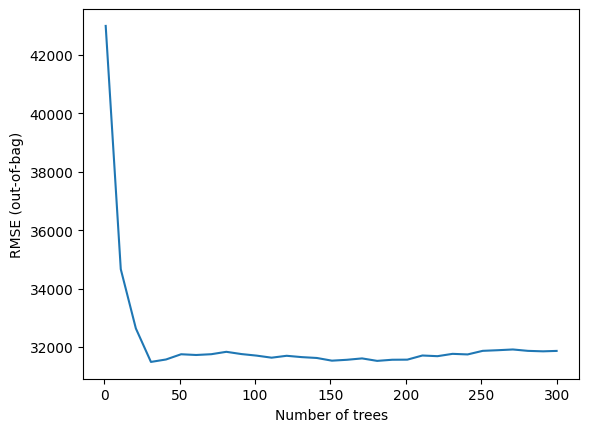

In [32]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [33]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1021, accuracy=None, loss=None, rmse=31864.443063801864, ndcg=None, aucs=None, auuc=None, qini=None)

In [34]:
evaluation = rf.evaluate(x=valid_ds, return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 850ms/step - loss: 0.0000e+00 - mse: 963332032.0000
loss: 0.0000
mse: 963332032.0000


#### Test data evaluation

In [35]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(testX, task = tfdf.keras.Task.REGRESSION)

In [65]:
preds = rf.predict(test_ds)

2/2 [==============================] - 2s 134ms/step


In [37]:
preds.shape, preds

((1459, 1),
 array([[122548.01 ],
        [157245.84 ],
        [177720.23 ],
        ...,
        [160814.31 ],
        [116887.625],
        [224823.25 ]], dtype=float32))

In [38]:
# getting Id info from the given test dataset
test_dataset = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')

In [39]:
submission_df = pd.DataFrame(columns= ['Id', 'SalePrice'])

In [58]:
submission_df['Id'] = test_dataset['Id']
submission_df['SalePrice'] = preds[:]

In [59]:
submission_df.head()

,Id,SalePrice
0,1461,103164.281250
1,1462,155636.734375
2,1463,174666.921875
3,1464,196923.734375
4,1465,175792.453125


In [60]:
submission_df.to_csv('submission.csv', index=False)